### Bayesian Methods - Bayesian Regression

##### 1. Bayesian Polynomial Regression

The temperature of a town in Sweden over one year is hypothesised to be able of being modelled as a quadratic polynomial. The regression model is described as:
$$
t_i =\mathbf{w}^{\text{T}}\mathbf{\phi}(x) = w_0 + w_1 x + w_2 x^2 + \varepsilon_i,~~ \varepsilon_i \overset{\text{iid}}{\sim} N(0, \sigma^2) ~~ \forall i \in \{1,\ldots,|D|\}
$$
In which: 
$$
D \triangleq \{(x_i, t_i), i\in \{1,\ldots,n\}\}
$$

$$
t_i: \text{Temperature in $^\circ C$}
$$

$$
x_i: \text{Fraction of a year passed}
$$

$$
\mathbf{\phi}(x) = [1~~~x~~~x^2]^{\text{T}}
$$

Normally, we could simply fit the parameters $\mathbf{w}$ using OLS or MLE by solving the normal equations. With the Bayesian approach however, we have a prior distribution for the parameters $\mathbf{w}$ and $\sigma$. With this prior distribution we can find a posterior one using the likelihood function of $t_i$. After which, it is easy to find the optimal parameters by maximizing the posterior probability (MAP).

The prior distribution for this problem is the following:

$$
p(\mathbf{w}|\sigma^2) \sim N_3(0, \sigma^2 \mathbf{\Omega}_0)
$$

$$
p(\sigma^2) \sim \text{Scale-Inv-}\chi^2(\nu_0, \sigma^2_0)
$$

Notice: the joint prior is split $p(\mathbf{w}, \sigma^2) = p(\mathbf{w}|\sigma^2)p(\sigma^2)$. 

This prior will correspond to Tikhonov (L2/Ridge) regularization.

In [7]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

In [86]:
df = pd.read_csv('data/TempLambohov.txt', delimiter='   ', engine='python')
df.insert(0, 'constant', np.ones(len(df)))
df.insert(2, 'time squared', df['time']**2)

# Design matrix and target vector.
X = np.array(df[df.columns[0:3]])
y = np.array(df['temp'])

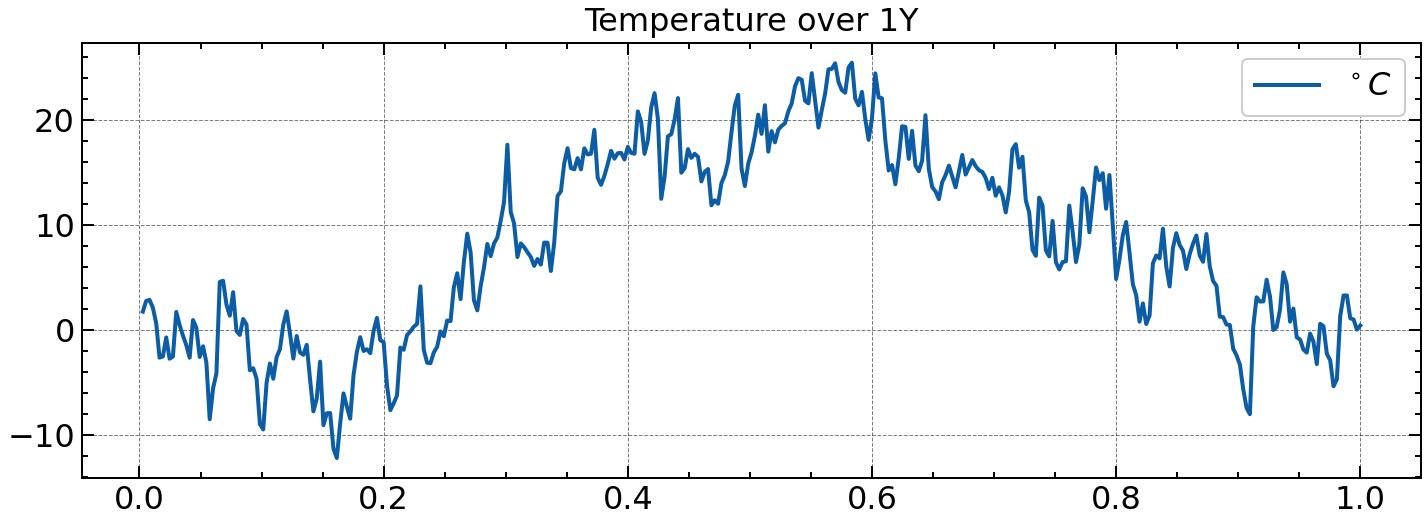

In [22]:
fig, ax = plt.subplots()

ax.plot(df['time'], df['temp'], label='$^\circ C$')
ax.set_title('Temperature over 1Y')
ax.legend()

fig.set_size_inches(12, 4)
plt.show()

##### Prior Distribution Hyperparameter Fit

In [105]:
# Prior Hyperparameters
mu_0 = np.array([-10, 100, -100])
omega_0 = 0.02 * np.identity(3)
nu_0 = 3
sigma_0 = 2

In [62]:
from scipy.stats import multivariate_normal, chi2

def simulate_prior_s(nu: float, sigma: float) -> np.array:
    chi2_variables = chi2.rvs(nu)
    return np.array(sigma * nu * (1 / chi2_variables))

def simulate_prior_w(mu: np.array, omega: np.array, sigma: float) -> np.array:
    return np.array(multivariate_normal.rvs(mu, sigma * omega))

In [96]:
def simulate_prior_curve(mu: np.array, omega: np.array, sigma: float, nu: float, size: int) -> list:
    set_of_curves = []
    for _ in range(size):
        sigma_sim = simulate_prior_s(nu, sigma)
        weights_sim = simulate_prior_w(mu, omega, sigma_sim)
        epsilon = multivariate_normal.rvs(np.zeros(len(df)), sigma_sim * np.identity(len(df)))
        y_sim = X @ weights_sim + epsilon
        set_of_curves.append(y_sim)
        
    return set_of_curves

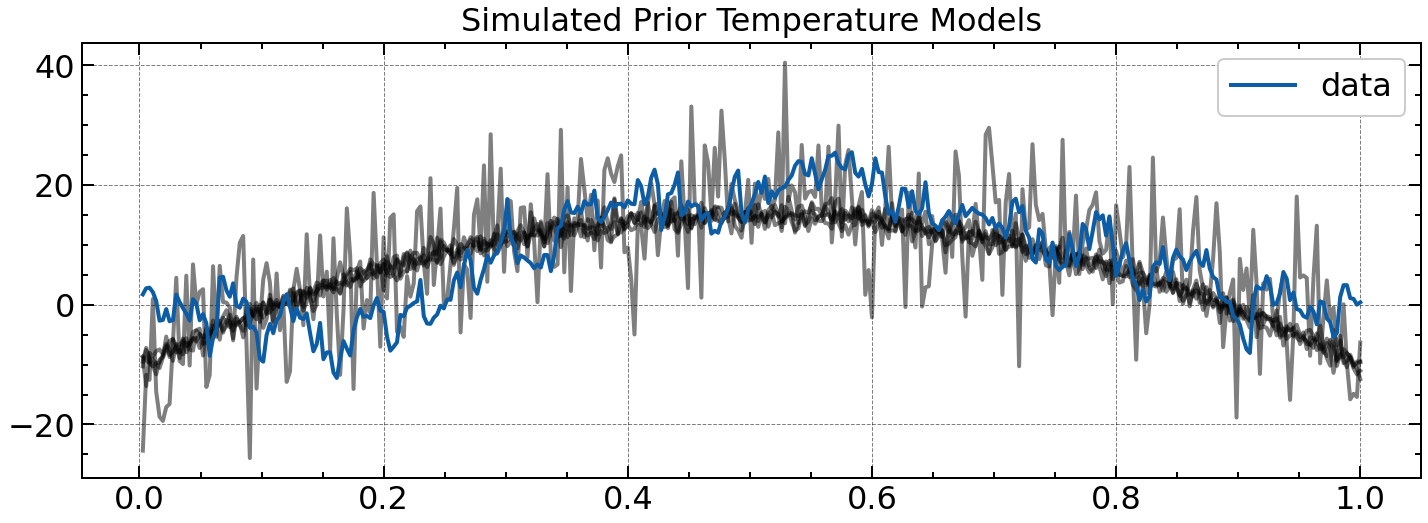

In [104]:
curves_sim = simulate_prior_curve(mu_0, omega_0, sigma_0, nu_0, 5)

fig, ax = plt.subplots()
for curve in curves_sim:
    ax.plot(df['time'], curve, color='black', alpha=0.5)
ax.plot(df['time'], y, label='data')
ax.legend()
ax.set_title('Simulated Prior Temperature Models')

fig.set_size_inches(12, 4)
plt.show()